In [ ]:
# for Colab
!pip install botorch

In [1]:
import torch
import botorch
import gpytorch

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel
from gpytorch.constraints.constraints import GreaterThan
from gpytorch.likelihoods import GaussianLikelihood

from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double # double == float64

# isn't this easier?
# https://github.com/pytorch/botorch/discussions/1444
torch.set_default_dtype(dtype)

# torch.set_default_device(device) # similarly

import numpy as np
import matplotlib.pyplot as plt

from generate_gp_data import GaussianProcessRandomDataset, FunctionSamplesMapDataset, FunctionSamplesAcquisitionDataset
from predict_EI_simple import calculate_EI_GP
from utils import get_uniform_randint_generator, loguniform_randint, get_loguniform_randint_generator, pad_tensor


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [11]:
from typing import Iterable

class Foo:
    def __iter__(self):
        pass

isinstance(Foo(), Iterable)

True

In [11]:
torch.linspace(0, 2, 5).unsqueeze(1)

tensor([[0.0000],
        [0.5000],
        [1.0000],
        [1.5000],
        [2.0000]])

In [12]:
torch.rand(5, 1)

tensor([[0.0224],
        [0.4601],
        [0.5239],
        [0.7331],
        [0.0724]])

In [105]:
a = torch.randn(3, 2)
print(a)
indices = torch.argmax(a, dim=1, keepdim=True)
print(torch.gather(a, 1, indices).shape)

tensor([[ 0.5853, -2.2724],
        [ 0.4816,  0.1837],
        [-0.7448, -0.5636]])
torch.Size([3, 1])


In [5]:
%load_ext autoreload
%autoreload 2

In [2]:
def plot_gp_posterior(ax, posterior, test_x, train_x, train_y, color, name=None):
    lower, upper = posterior.mvn.confidence_region()
    mean = posterior.mean.squeeze().cpu().numpy()
    lower = lower.squeeze().cpu().numpy()
    upper = upper.squeeze().cpu().numpy()

    train_x = train_x.squeeze().cpu().numpy()
    train_y = train_y.squeeze().cpu().numpy()
    test_x = test_x.squeeze().cpu().numpy()

    extension = '' if name is None else f' {name}'

    # Plot training points as black stars
    ax.plot(train_x, train_y, f'{color}*', label=f'Observed Data{extension}')
    # Plot posterior means as blue line
    ax.plot(test_x, mean, color, label=f'Mean{extension}')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x, lower, upper, color=color, alpha=0.5, label=f'Confidence{extension}')

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


likelihood.noise_covar.raw_noise Parameter containing:
tensor([0.])

mean_module.raw_constant Parameter containing:
tensor(0., requires_grad=True)

covar_module.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)

covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[0.]], requires_grad=True)

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])), ('likelihood.noise_covar.raw_noise_constraint.lower_bound', tensor(0.)), ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)), ('mean_module.raw_constant', tensor(0.)), ('covar_module.raw_outputscale', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])), ('covar_module.base_kernel.lengthscale_prior.concentration', tensor(3.)), ('covar_module.base_kernel.lengthscale_prior.rate', tensor(6.)), ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound', tensor(inf)), ('cova

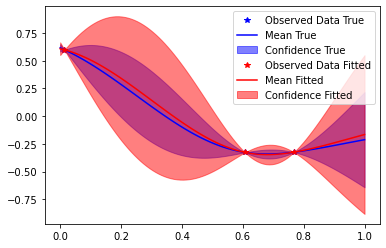

In [3]:
# randint_gen = get_uniform_randint_generator(4, 20)
# dataset = GaussianProcessRandomDataset(
#     dimension=1, n_datapoints_random_gen=randint_gen, observation_noise=False,
#     device=device)

# torch.manual_seed(1703)

OBSERVATION_NOISE = False

kernel = ScaleKernel(RBFKernel())
kernel.initialize(**{'base_kernel.lengthscale': torch.tensor(0.2)})
likelihood = GaussianLikelihood(
    noise_prior=None, batch_shape=torch.Size(),
    noise_constraint=GreaterThan(
        0.0, transform=None, initial_value=0.2
    )
)
train_X = torch.zeros(0, 1, device=device)
train_Y = torch.zeros(0, 1, device=device)

models = [SingleTaskGP(train_X, train_Y, likelihood=likelihood, covar_module=kernel)]

# This is unsupported:
# train_Yvar = torch.full_like(train_Y, 1e-6)
# models =[
#     SingleTaskGP(train_X, train_Y, train_Yvar)
#     ]

dataset = GaussianProcessRandomDataset(
    dimension=1, n_datapoints=3, observation_noise=OBSERVATION_NOISE,
    set_random_model_train_data=True, device=device,
    randomize_params=False, models=None) # or models=None to make default

# dataset = GaussianProcessRandomDataset(
#     dimension=1, n_datapoints_random_gen=get_uniform_randint_generator(1, 8), 
#     observation_noise=OBSERVATION_NOISE,
#     set_random_model_train_data=True, device=device,
#     randomize_params=False, models=models) # or models=None to make default

for name, param in dataset.model_sampler.get_model(0).named_parameters(): 
    print(name, param)
    print()

print(dataset.model_sampler.get_model(0).state_dict())

x_values, y_values, model = next(dataset)

print(model)

true_lengthscale = model.covar_module.base_kernel.lengthscale.squeeze().detach().clone().numpy()
true_outputscale = model.covar_module.outputscale.squeeze().detach().clone().numpy()
true_noise = model.likelihood.noise_covar.noise.squeeze().detach().clone().numpy()

test_x = torch.linspace(0, 1, 100, device=device)

# Get posterior under true model parameters
posterior_true = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)


print("true model")
for name, param in model.named_parameters(): 
    print(name, param)
    print()

# Get posterior by fitting by MAP
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
posterior_fitted = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)
fitted_model = model

fitted_lengthscale = fitted_model.covar_module.base_kernel.lengthscale.squeeze().detach().clone().numpy()
fitted_outputscale = fitted_model.covar_module.outputscale.squeeze().detach().clone().numpy()
fitted_noise = fitted_model.likelihood.noise_covar.noise.squeeze().detach().clone().numpy()

print("fitted model")
for name, param in fitted_model.named_parameters(): 
    print(name, param)
    print()


with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    description_true   = f'True:   l={  true_lengthscale:.3g}, sigma^2={  true_outputscale:.3g}, noise={true_noise:.3g}'
    description_fitted = f'Fitted: l={fitted_lengthscale:.3g}, sigma^2={fitted_outputscale:.3g}, noise={fitted_noise:.3g}'
    print(description_true)
    print(description_fitted)
    
    plot_gp_posterior(ax, posterior_true, test_x, x_values, y_values, 'b', name='True')
    plot_gp_posterior(ax, posterior_fitted, test_x, x_values, y_values, 'r', name='Fitted')

    ax.legend()

In [27]:
from torch.distributions import Categorical
import torch.nn.functional as F

p_tensor = torch.Tensor([[0.1, 0.2, 0.4, 0.3], [0.25, 0.25, 0.25, 0.25], [0.0, 1.0, 0.0, 0.0]])
entropy2 = Categorical(probs = p_tensor).entropy()
print(entropy2, -(p_tensor * torch.log(p_tensor)).sum(axis=1))

def max_one_hot(values, mask=None):
    if mask is not None:
        neg_inf = torch.zeros_like(values)
        neg_inf[~mask] = float("-inf")
        values = values + neg_inf
    return F.one_hot(torch.argmax(values, dim=1),
                     num_classes=values.size(1)).double()

max_one_hot(p_tensor)

tensor([1.2799e+00, 1.3863e+00, 2.2204e-16]) tensor([1.2799, 1.3863,    nan])


tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]])

In [14]:
class Foo:
    def __init__(self, v):
        self._v = v
    
    @property
    def v(self):
        return self._v

c = Foo(6)
c.v = 5
c.v

AttributeError: can't set attribute

In [41]:
def get_average_normalized_entropy(probabilities, mask=None):
    entropy = Categorical(probs=probabilities).entropy()
    counts = mask.sum(dim=1).double() if mask is not None else torch.tensor(probabilities.size(1), dtype=torch.double)
    return (entropy / torch.log(counts)).mean()

p_tensor = torch.Tensor([[0.1, 0.2, 0.4, 0.3], [0.5, 0.5, 0.0, 0.0]])
get_average_normalized_entropy(p_tensor, mask=torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])).item()

0.9616098361677539

In [8]:
item1 = next(dataset)
print(item1[-1].state_dict())
item2 = next(dataset)
print(item1[-1].state_dict())
print(item2[-1].state_dict())

print(list(item1[-1].named_parameters()))
print()

print([name for name, param in item1[-1].named_parameters()])
print([name for name in item1[-1].state_dict()])

# https://docs.gpytorch.ai/en/stable/_modules/gpytorch/module.html#Module.named_priors
model1 = item1[-1]
print(list(model1.named_priors()))


OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])), ('likelihood.noise_covar.raw_noise_constraint.lower_bound', tensor(0.)), ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)), ('mean_module.raw_constant', tensor(0.0303)), ('covar_module.raw_outputscale', tensor(7.0973)), ('covar_module.base_kernel.raw_lengthscale', tensor([[-1.6044]])), ('covar_module.base_kernel.lengthscale_prior.concentration', tensor(3.)), ('covar_module.base_kernel.lengthscale_prior.rate', tensor(6.)), ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound', tensor(inf)), ('covar_module.outputscale_prior.concentration', tensor(2.)), ('covar_module.outputscale_prior.rate', tensor(0.1500)), ('covar_module.raw_outputscale_constraint.lower_bound', tensor(0.)), ('covar_module.raw_outputscale_constraint.upper_bound', tensor(inf))])
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


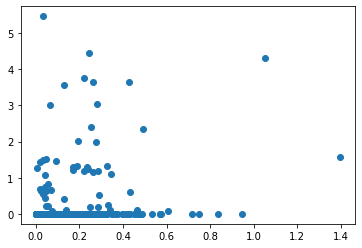

In [6]:
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()


OBSERVATION_NOISE = False
dataset = GaussianProcessRandomDataset(
    dimension=5, n_datapoints=20, observation_noise=OBSERVATION_NOISE,
    set_random_model_train_data=False, device=device)

n_samples = 1000

ei_values = torch.empty(n_samples, device=device)
improvement_values = torch.empty(n_samples, device=device)


with torch.no_grad():
    for i in range(n_samples):
        x_values, y_values, random_model = next(dataset)

        # x_values is shape (n_datapoints, dimension)
        # y_values is shape (n_datapoints,)
        x_hist = x_values[:-1, :]
        y_hist = y_values[:-1]
        x = x_values[-1:, :]
        y = y_values[-1:]
        
        ei_value, improvement_value = calculate_EI_GP(random_model, x_hist, y_hist, x, y, fit_params=False)
        ei_values[i] = ei_value[0]
        improvement_values[i] = improvement_value[0]

    # print(ei_values)
    # print(improvement_values)


# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

plt.scatter(ei_values.cpu().numpy(), improvement_values.cpu().numpy())

In [29]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, start, end):
        super(MyIterableDataset).__init__()
        assert end > start, "this example code only works with end >= start"
        self.start = start
        self.end = end

    def __iter__(self):
        return iter(range(self.start, self.end))

for x in MyIterableDataset(3, 7):
    print(x)


3
4
5
6


In [36]:
u = torch.rand(8, 3)
print(u)
rand_indices = torch.randperm(u.shape[0])
print(rand_indices)
print(u[rand_indices])
print(u[rand_indices[:3]])
print(u[rand_indices[3:]])

tensor([[0.4321, 0.9570, 0.2413],
        [0.7917, 0.6027, 0.1502],
        [0.7692, 0.3887, 0.8973],
        [0.2957, 0.0481, 0.0261],
        [0.6843, 0.2177, 0.8816],
        [0.1277, 0.4359, 0.3886],
        [0.0205, 0.9009, 0.2009],
        [0.2266, 0.2300, 0.7466]])
tensor([2, 6, 5, 4, 3, 0, 7, 1])
tensor([[0.7692, 0.3887, 0.8973],
        [0.0205, 0.9009, 0.2009],
        [0.1277, 0.4359, 0.3886],
        [0.6843, 0.2177, 0.8816],
        [0.2957, 0.0481, 0.0261],
        [0.4321, 0.9570, 0.2413],
        [0.2266, 0.2300, 0.7466],
        [0.7917, 0.6027, 0.1502]])
tensor([[0.7692, 0.3887, 0.8973],
        [0.0205, 0.9009, 0.2009],
        [0.1277, 0.4359, 0.3886]])
tensor([[0.6843, 0.2177, 0.8816],
        [0.2957, 0.0481, 0.0261],
        [0.4321, 0.9570, 0.2413],
        [0.2266, 0.2300, 0.7466],
        [0.7917, 0.6027, 0.1502]])


In [45]:
q = torch.rand(20)
q - 10.0

tensor([-9.5747, -9.7501, -9.6260, -9.5177, -9.1595, -9.5724, -9.6298, -9.1459,
        -9.6044, -9.6240, -9.6702, -9.5881, -9.5899, -9.7063, -9.1460, -9.7534,
        -9.3527, -9.5060, -9.5050, -9.8674])

In [50]:
list[dict]

list[dict]

In [49]:
isinstance(dataset, torch.utils.data.IterableDataset)

True

In [58]:
{x:y for x, y in model.named_parameters()}

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([0.], requires_grad=True),
 'mean_module.raw_constant': Parameter containing:
 tensor(0.0074, requires_grad=True),
 'covar_module.raw_outputscale': Parameter containing:
 tensor(14.9644, requires_grad=True),
 'covar_module.base_kernel.raw_lengthscale': Parameter containing:
 tensor([[0.8065]], requires_grad=True)}

In [59]:
{x:y.detach() for x, y in model.named_parameters()}

{'likelihood.noise_covar.raw_noise': tensor([0.]),
 'mean_module.raw_constant': tensor(0.0074),
 'covar_module.raw_outputscale': tensor(14.9644),
 'covar_module.base_kernel.raw_lengthscale': tensor([[0.8065]])}

In [22]:
model.index

0

In [26]:
fixed_dataset = FunctionSamplesMapDataset.from_iterable_dataset(dataset, 1000)
fixed_dataset.save("data")

In [30]:
fixed_dataset[0][0]

tensor([[0.8489, 0.1965, 0.0284, 0.0234, 0.1666],
        [0.8518, 0.9975, 0.9318, 0.0532, 0.1928],
        [0.9660, 0.5656, 0.1563, 0.1609, 0.0425],
        [0.4375, 0.4648, 0.2420, 0.1713, 0.9196],
        [0.0546, 0.8694, 0.4443, 0.5036, 0.8704],
        [0.9682, 0.4215, 0.7049, 0.4719, 0.8775],
        [0.6631, 0.9408, 0.6663, 0.5284, 0.6014],
        [0.8294, 0.9148, 0.5544, 0.8021, 0.8817],
        [0.7465, 0.8460, 0.5765, 0.1917, 0.8225],
        [0.2578, 0.8584, 0.0147, 0.4841, 0.8581],
        [0.8904, 0.7481, 0.0781, 0.5039, 0.5400],
        [0.1587, 0.6665, 0.6906, 0.8259, 0.9701],
        [0.1105, 0.4084, 0.0324, 0.1800, 0.1766],
        [0.9080, 0.4782, 0.8625, 0.7269, 0.8146],
        [0.5159, 0.9522, 0.1116, 0.6569, 0.7407],
        [0.7568, 0.2690, 0.5293, 0.2926, 0.5500],
        [0.6386, 0.7783, 0.5267, 0.3157, 0.0216],
        [0.3528, 0.7596, 0.1990, 0.9174, 0.3976],
        [0.2512, 0.9899, 0.4709, 0.1600, 0.5643],
        [0.7841, 0.6821, 0.1907, 0.4530, 0.0499]])

In [33]:
fixed_dataset_loaded = FunctionSamplesMapDataset.load("data")
fixed_dataset_loaded[0][2].index

0

In [12]:
test_dataset = FunctionSamplesMapDataset([
    {'x_values': [i], 
     'y_values': [i]}
     for i in range(20)
] + [{'x_values': [12, 13], 'y_values': [33]}])

# test_dataset = GaussianProcessRandomDataset(
#     dimension=2, n_datapoints=4, observation_noise=OBSERVATION_NOISE,
#     set_random_model_train_data=False, device=device)


data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,
                                        #   sampler=torch.utils.data.RandomSampler(test_dataset, replacement=False, num_samples=200)
                                          )

for x in test_dataset:
    print(x)




([0], [0])
([1], [1])
([2], [2])
([3], [3])
([4], [4])
([5], [5])
([6], [6])
([7], [7])
([8], [8])
([9], [9])
([10], [10])
([11], [11])
([12], [12])
([13], [13])
([14], [14])
([15], [15])
([16], [16])
([17], [17])
([18], [18])
([19], [19])
([12, 13], [33])


In [37]:
hasattr(test_dataset, '_model_sampler')
 # "Generating GP realizations:"

False

In [7]:
rand_dataset = GaussianProcessRandomDataset(n_datapoints=15, dimension=5, dataset_size=94)
function_samples_dataset = FunctionSamplesMapDataset.from_iterable_dataset(rand_dataset, 123)
function_samples_dataset = function_samples_dataset[:20]
function_samples_dataset.save('fixed', 17)
rand_dataset.save('random')
loaded_dataset = FunctionSamplesMapDataset.load('fixed')
print(len(loaded_dataset))

Saving realizations from GaussianProcessRandomDataset into FunctionSamplesMapDataset


100%|██████████| 123/123 [00:00<00:00, 211.47it/s]


Generating and saving realizations from GaussianProcessRandomDataset


100%|██████████| 94/94 [00:00<00:00, 281.50it/s]

17


In [10]:
len(function_samples_dataset), len(loaded_dataset)

(100, 100)

In [17]:
for (x1,y1,z1), (x2,y2,z2) in zip(loaded_dataset, function_samples_dataset):
    assert torch.allclose(x1, x2)
    assert torch.allclose(y1, y2)

In [3]:
function_samples_dataset_2 = FunctionSamplesMapDataset.from_iterable_dataset(function_samples_dataset, 100)

In [ ]:
loaded_dataset[0][2]

In [ ]:
function_samples_dataset_2[0][2]

In [12]:
from collections.abc import Sequence
import numpy as np
print(isinstance([1, 2, 3], Sequence))
print(isinstance((1,2,3), Sequence))
print(isinstance(np.array([1,5,5]), Sequence))

True
True
False


In [6]:
len(np.array([1,5,5]))

3

In [8]:
np.array([1,5,5])[0]

1

In [9]:
qq = [1]
try:
    a = qq[1]
except TypeError:
    print("IndexError")

IndexError


In [39]:
import torch
int(torch.distributions.Binomial(10, 0.5).sample())

4

In [3]:
from generate_gp_data import GaussianProcessRandomDataset, FunctionSamplesMapDataset, FunctionSamplesAcquisitionDataset

N_CANDIDATES = 12
MAX_HISTORY = 30
HISTORY_LOGUNIFORM = True

if HISTORY_LOGUNIFORM:
    randint_gen = get_loguniform_randint_generator(
        1, MAX_HISTORY, pre_offset=3.0, offset=N_CANDIDATES)
else:
    randint_gen = get_uniform_randint_generator(
        N_CANDIDATES+1, N_CANDIDATES+MAX_HISTORY)

dataset = GaussianProcessRandomDataset(
    dimension=6, n_datapoints_random_gen=randint_gen, observation_noise=False,
    set_random_model_train_data=False, device=device, dataset_size=20)
dataset = FunctionSamplesMapDataset.from_iterable_dataset(dataset, 10)

aq_dataset = FunctionSamplesAcquisitionDataset(
    dataset, n_candidate_points=N_CANDIDATES, n_samples="all", give_improvements=True, min_n_candidates=2, dataset_size_factor=3)

train_aq_dataset, test_aq_dataset = aq_dataset.random_split([0.8, 0.2])

print("dataset:")
for x, y, model in dataset:
    print(x.shape, y.shape)
    # print(list(model.named_parameters()))
print()

print("aq_dataset:")
for x_hist, y_hist, x_cand, improvements, model in aq_dataset:
    print(x_hist.shape, y_hist.shape, x_cand.shape, improvements.shape)
print()

print("train_aq_dataset:")
for x_hist, y_hist, x_cand, improvements, model in train_aq_dataset:
    print(x_hist.shape, y_hist.shape, x_cand.shape, improvements.shape)
print()

print("test_aq_dataset:")
for x_hist, y_hist, x_cand, improvements, model in test_aq_dataset:
    print(x_hist.shape, y_hist.shape, x_cand.shape, improvements.shape)
print()

print(list(dataset.model_sampler.initial_models[0].named_parameters()))


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


Generating GP realizations:


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 33.04it/s]

dataset:
torch.Size([35, 6]) torch.Size([35])
torch.Size([20, 6]) torch.Size([20])
torch.Size([21, 6]) torch.Size([21])
torch.Size([38, 6]) torch.Size([38])
torch.Size([13, 6]) torch.Size([13])
torch.Size([37, 6]) torch.Size([37])
torch.Size([18, 6]) torch.Size([18])
torch.Size([17, 6]) torch.Size([17])
torch.Size([19, 6]) torch.Size([19])
torch.Size([17, 6]) torch.Size([17])

aq_dataset:
torch.Size([26, 6]) torch.Size([26]) torch.Size([12, 6]) torch.Size([12])
torch.Size([25, 6]) torch.Size([25]) torch.Size([12, 6]) torch.Size([12])
torch.Size([7, 6]) torch.Size([7]) torch.Size([12, 6]) torch.Size([12])
torch.Size([5, 6]) torch.Size([5]) torch.Size([12, 6]) torch.Size([12])
torch.Size([6, 6]) torch.Size([6]) torch.Size([12, 6]) torch.Size([12])
torch.Size([8, 6]) torch.Size([8]) torch.Size([12, 6]) torch.Size([12])
torch.Size([1, 6]) torch.Size([1]) torch.Size([12, 6]) torch.Size([12])
torch.Size([5, 6]) torch.Size([5]) torch.Size([12, 6]) torch.Size([12])
torch.Size([9, 6]) torch.Siz

In [8]:
from generate_gp_data import FunctionSamplesDataset
from torch.utils.data import IterableDataset

dataset = GaussianProcessRandomDataset(
    dimension=6, n_datapoints_random_gen=randint_gen, observation_noise=False,
    set_random_model_train_data=False, device=device, dataset_size=20)
print(isinstance(dataset, FunctionSamplesDataset), isinstance(dataset, IterableDataset))
dataset = FunctionSamplesMapDataset.from_iterable_dataset(dataset)

print(FunctionSamplesMapDataset._resize_iterable_dataset)

dataset = dataset[:-3]

# v = iter(dataset)
# for _ in range(2):
#     print(next(v))

train_dataset, test_dataset = dataset.random_split([0.8, 0.2])
print(type(train_dataset))
train_subset_1, train_subset_2 = train_dataset.random_split([0.8, 0.2])
print(type(train_subset_1), len(train_subset_1))
# train_subset_1 = train_subset_1[:4]
# print(type(train_subset_1), len(train_subset_1))
train_subset_1.save('train')
loaded_train = FunctionSamplesMapDataset.load('train')
for x, y, model in loaded_train:
    print(x.shape, y.shape)
    print(list(model.named_parameters()))
    print()

print(len(dataset), len(train_dataset), len(loaded_train), len(train_subset_1))

print('\n')

aq1 = FunctionSamplesAcquisitionDataset(
    train_subset_1, n_candidate_points=N_CANDIDATES, n_samples="all", give_improvements=True, min_n_candidates=2, dataset_size_factor=1)
dataloader = aq1.get_dataloader(batch_size=3, drop_last=True)
for x_hist, y_hist, x_cand, vals_cand, hist_mask, cand_mask, models in dataloader:
    print(x_hist.shape, y_hist.shape, x_cand.shape, vals_cand.shape,
          hist_mask if hist_mask is None else hist_mask.shape,
          cand_mask if cand_mask is None else cand_mask.shape)
    print([type(model) for model in models])
    print()



# aq_dataset = FunctionSamplesAcquisitionDataset(
#     dataset, n_candidate_points=N_CANDIDATES, n_samples="all", give_improvements=True, min_n_candidates=2)
# v = iter(aq_dataset)
# for _ in range(2):
#     print(next(v))
# train_aq_dataset, test_aq_dataset = aq_dataset.random_split([20, 10])

True True
Generating GP realizations:


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 178.55it/s]

<bound method FunctionSamplesMapDatasetBase._resize_iterable_dataset of <class 'generate_gp_data.FunctionSamplesMapDataset'>>
<class 'generate_gp_data.FunctionSamplesMapSubset'>
<class 'generate_gp_data.FunctionSamplesMapSubset'> 12
torch.Size([21, 6]) torch.Size([21])


[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.])), ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(13.5610, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-0.3877, -0.0363, -0.1053, -1.5243, -0.9036, -0.3979]],
       requires_grad=True))]

torch.Size([29, 6]) torch.Size([29])
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.])), ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.raw_outputscale', Parameter containing:
tensor(15.4849, requires_grad=True)), ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-1.0091, -0.0928, -0.5532, -0.2657, -0.4310,  1.2274]],
       requires_grad=True))]

torch.Size([14, 6]) torch.Size([14])
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.])), ('mean_module.raw_const

In [4]:
dataset = GaussianProcessRandomDataset(
    dimension=6, n_datapoints_random_gen=randint_gen, observation_noise=False,
    set_random_model_train_data=False, device=device, dataset_size=None)
v = iter(dataset)
v

In [29]:
w = torch.rand(10, 4)
w.unsqueeze(-1).shape

torch.Size([10, 4, 1])

In [9]:
list(zip(*[(1,2), (3,4)]))

[(1, 3), (2, 4)]

In [12]:
from typing import Iterable, Optional


class SizedIterableMixin(Iterable):
    _size: Optional[int] = None

    def copy_with_new_size(self, size:int) -> "SizedIterableMixin":
        """
        Creates a copy of the object with a new size.
        Should set the _size attribute of the new object to the specified size.

        Args:
            size (int): The new size for the object.

        Returns:
            A new instance of the object with the specified size.
        """
        raise NotImplementedError("Subclasses of SizedIterableMixin should implement copy_with_new_size.")

    def _next(self):
        """Returns the next element in the iterable."""
        raise NotImplementedError("Subclasses of SizedIterableMixin should implement _next.")

    def __iter__(self):
        if self._size is None:
            # print("SizedIterableMixin.__iter__")
            return self
        else:
            return self._finite_iterator()
    
    def _finite_iterator(self):
        for _ in range(self._size):
            yield self._next()
    
    def __len__(self):
        if self._size is None:
            raise TypeError(f"Length of the {type(self)} is infinite")
        return self._size

    def __next__(self):
        if self._size is None:
            # print("SizedIterableMixin.__next__")
            return self._next()
        raise TypeError(f"Cannot call __next__ on a finitely sized {type(self)}. Use iter() first.")


# Example subclass implementation
class Example(SizedIterableMixin):
    def __init__(self, size: Optional[int]):
        self._size = size
        self.current = 0

    def _next(self):
        result = self.current
        self.current += 1
        return result

    def copy_with_new_size(self, size: int) -> "Example":
        return Example(size)


# Demonstration
dataset = Example(None)  # Infinite size
v = iter(dataset)
print(next(v))  # Output: 0
print(next(v))  # Output: 1

dataset_finite = Example(5)  # Finite size
v_finite = iter(dataset_finite)
print(list(v_finite))  # Output: [0, 1, 2, 3, 4]

0
1
[0, 1, 2, 3, 4]


In [5]:
len(dataset)

TypeError: Length of the <class 'generate_gp_data.GaussianProcessRandomDataset'> is infinite

In [ ]:
train_aq

In [24]:
test_split_1, test_split_2 = test_aq_dataset.random_split([0.5, 0.5])

data_loader = test_split_2.get_dataloader(batch_size=2, drop_last=False)

for x_hist, y_hist, x_cand, improvements, model in data_loader:
    print(x_hist.shape, y_hist.shape, x_cand.shape, improvements.shape)

torch.Size([2, 3, 6]) torch.Size([2, 3]) torch.Size([2, 1, 6]) torch.Size([2, 1])
torch.Size([1, 3, 6]) torch.Size([1, 3]) torch.Size([1, 1, 6]) torch.Size([1, 1])


In [26]:
type(test_split_2.base_dataset)

generate_gp_data.FunctionSamplesMapSubset

In [27]:
test_split_2.base_dataset

In [31]:
from torch.masked import masked_tensor

def pad_tensor(vec, length, dim, add_mask=True):
    """
    Pads a tensor 'vec' to a size 'length' in dimension 'dim' with zeros.
    args:
        vec - tensor to pad
        length - the size to pad to in dimension 'dim'
        dim - dimension to pad
        add_mask - whether to return a MaskedTensor that includes the mask

    return:
        a new tensor padded to 'length' in dimension 'dim'
    """
    pad_size = length - vec.size(dim)
    if pad_size < 0:
        raise ValueError("Tensor cannot be padded to length less than it already is")
    
    vec_shape = list(vec.shape)
    pad_shape = vec_shape.copy()
    pad_shape[dim] = pad_size
    if pad_size == 0: # Could pad with nothing but that's unnecessary
        padded = vec
    else:
        padding = torch.ones(*pad_shape, dtype=vec.dtype, device=vec.device)
        padded = torch.cat([vec, padding], dim=dim)

    if add_mask:
        mask_true = torch.ones(vec.shape, dtype=torch.bool, device=vec.device)
        mask_false = torch.zeros(*pad_shape, dtype=torch.bool, device=vec.device)
        mask = torch.cat([mask_true, mask_false], dim=dim)
        padded_masked = masked_tensor(padded, mask)
        return padded, padded_masked

    return padded

data = torch.randn(4, 3)
padded, padded_masked = pad_tensor(data, 6, dim=0, add_mask=True)

print(padded)
print(padded_masked.get_mask())

data2 = torch.randn(6)
data2 = masked_tensor(data2, torch.ones_like(data2, dtype=torch.bool))
data2 = data2.unsqueeze(-1)
print(data2)
print(padded_masked)
data3 = torch.cat((padded_masked, data2), dim=1)
print(data3)
print(data3.shape)
print(data3.get_mask())



# linear = torch.nn.Linear(4, 2)
# result = linear(data3)
# print(result)

tensor([[-0.4083, -1.7979, -0.4755],
        [ 1.1438, -1.4784, -0.8719],
        [-0.5840,  1.3183, -1.9384],
        [-0.0928, -1.0771,  0.1488],
        [ 1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000]])
tensor([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False, False],
        [False, False, False]])
MaskedTensor(
  [
    [  0.6548],
    [  0.6184],
    [  0.1261],
    [ -1.2328],
    [ -0.5295],
    [  0.8754]
  ]
)
MaskedTensor(
  [
    [ -0.4083,  -1.7979,  -0.4755],
    [  1.1438,  -1.4784,  -0.8719],
    [ -0.5840,   1.3183,  -1.9384],
    [ -0.0928,  -1.0771,   0.1488],
    [      --,       --,       --],
    [      --,       --,       --]
  ]
)
MaskedTensor(
  [
    [ -0.4083,  -1.7979,  -0.4755,   0.6548],
    [  1.1438,  -1.4784,  -0.8719,   0.6184],
    [ -0.5840,   1.3183,  -1.9384,   0.1261],
    [ -0.0928,  -1.0771,   0.1488,  -1.2328],
    [      --,       --,      

In [12]:
import torch
import torch.nn as nn

# Dimensions
N = 10  # Number of y_i vectors
d = 20  # Dimension of x
p = 30  # Dimension of output
m = 256  # Dimension of y_i

# Example inputs
x = torch.randn(d, 1, requires_grad=False)  # (d, 1)
y = torch.randn(m, N, requires_grad=False)  # (m, N)

# Define the linear layers
linear_layer_a = nn.Linear(d + m, p)
linear_layer_x = nn.Linear(d, p)
linear_layer_y = nn.Linear(m, p, bias=False)

# Manually set the weights and biases to ensure they are the same
with torch.no_grad():
    # Combine weights and biases for the linear layer in Approach (a)
    combined_weight = torch.cat((linear_layer_x.weight, linear_layer_y.weight), dim=1)
    linear_layer_a.weight.copy_(combined_weight)
    linear_layer_a.bias.copy_(linear_layer_x.bias)

# Approach (a): Stacking and Applying a Single Linear Layer
x_repeated = x.t().repeat(N, 1)  # (N, d)
input_matrix = torch.cat((x_repeated, y.t()), dim=1)  # (N, d + m)
output_a = linear_layer_a(input_matrix)  # (N, p)
output_a.sum().backward()
grad_x_a = x.grad.clone()
grad_y_a = y.grad.clone()

# Reset gradients
x.grad.zero_()
y.grad.zero_()

# Approach (b): Separate Linear Layers and Summing Results
output_x = linear_layer_x(x.t()).repeat(N, 1)  # (N, p)
output_y = linear_layer_y(y.t())  # (N, p)
output_b = output_x + output_y  # (N, p)
output_b.sum().backward()
grad_x_b = x.grad.clone()
grad_y_b = y.grad.clone()

# Compare gradients
print("Gradient w.r.t x (Approach a):", grad_x_a)
print("Gradient w.r.t x (Approach b):", grad_x_b)
print("Gradients w.r.t x are equal:", torch.allclose(grad_x_a, grad_x_b, atol=1e-6))

print("Gradient w.r.t y (Approach a):", grad_y_a)
print("Gradient w.r.t y (Approach b):", grad_y_b)
print("Gradients w.r.t y are equal:", torch.allclose(grad_y_a, grad_y_b, atol=1e-6))


False


AttributeError: 'NoneType' object has no attribute 'clone'

In [ ]:
from torch.masked import masked_tensor

data = torch.arange(24).reshape(2, 3, 4).float()
mask = data % 2 == 0

print("data:\n", data)
print(f"mask: {mask.dtype}\n", mask)
mt = masked_tensor(data, mask)
print("data masked:\n", mt)

data2 = torch.randn(2, 3, 4)
mt2 = masked_tensor(data2, mask)
print("data2 masked:\n", mt2)

stacked_masked = torch.vstack([mt, mt2])
print("stacked_masked:\n", stacked_masked)


In [1]:
x = torch.tensor([True, False, True])
y = torch.tensor([2.5, 0.0, 1.7])
y

NameError: name 'torch' is not defined

In [41]:

import torch

x = torch.tensor([True, False, True])
y = torch.tensor([2.5, 0.0, 1.7])

z = x * y  # or z = torch.bitwise_and(x, y)
print(z)

tensor([2.5000, 0.0000, 1.7000])


(array([ 40.,   0.,   0.,   0.,   0.,   0.,  37.,   0.,   0.,   0.,  28.,
          0.,   0.,  28.,   0.,   0.,  35.,  28.,   0.,  28.,  38.,  32.,
          0.,  71.,  34.,  31.,  28.,  67.,  64.,  73.,  53.,  68., 110.,
        101.,  95.,  94., 154., 121., 170., 171., 215., 195., 237., 297.,
        324., 303., 384., 381., 431., 454., 524., 561., 659., 683., 762.,
        861., 930.]),
 array([0.        , 0.10006636, 0.20013272, 0.30019908, 0.40026544,
        0.5003318 , 0.60039816, 0.70046451, 0.80053087, 0.90059723,
        1.00066359, 1.10072995, 1.20079631, 1.30086267, 1.40092903,
        1.50099539, 1.60106175, 1.70112811, 1.80119447, 1.90126082,
        2.00132718, 2.10139354, 2.2014599 , 2.30152626, 2.40159262,
        2.50165898, 2.60172534, 2.7017917 , 2.80185806, 2.90192442,
        3.00199078, 3.10205714, 3.20212349, 3.30218985, 3.40225621,
        3.50232257, 3.60238893, 3.70245529, 3.80252165, 3.90258801,
        4.00265437, 4.10272073, 4.20278709, 4.30285345, 4.402919

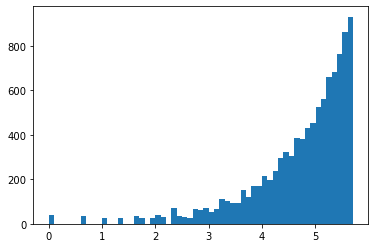

In [44]:
min_val = 1
max_val = 300
vals = torch.randint(min_val, max_val+1, (10_000,), dtype=torch.float64)

data = torch.log(vals).numpy()
plt.hist(data, bins='auto')

In [51]:
from torch.distributions import Uniform
m = Uniform(torch.tensor(0.0), torch.tensor(5.0))
m.sample

<bound method Distribution.sample of Uniform(low: 0.0, high: 5.0)>

In [54]:
torch.as_tensor(3, dtype=torch.float64)

tensor(3.)

In [10]:
u = [3,4,5]
v = u
v = v[:2]

u, v

([3, 4, 5], [3, 4])

In [13]:
class A:
    def method(self):
        print("Method from class A")

class B(A):
    def method(self):
        print("Method from class B")
        super().method()

class C(A):
    def method(self):
        print("Method from class C")
        super().method()

class D(B, C):
    def method(self):
        print("Method from class D")
        super().method()

# Demonstration
d = D()
d.method()

Method from class D
Method from class B
Method from class C
Method from class A


In [14]:
len(d)

TypeError: object of type 'D' has no len()

In [55]:
torch.as_tensor(3).to(dtype=torch.float64)

tensor(3.)

In [60]:
torch.as_tensor(3).to(dtype=torch.int32).dtype

torch.int32

In [76]:
torch.log(torch.tensor(9813))

tensor(9.1915)

In [87]:
int(torch.exp(torch.rand(1)).item())

2

In [92]:
torch.exp(torch.rand(10)).to(dtype=torch.int32) + 44

tensor([45, 46, 46, 45, 45, 45, 45, 45, 45, 46], dtype=torch.int32)

In [224]:

vals = loguniform_randint(1, 1000, 1000, pre_offset=15.0)
print(vals)

# fig = plt.figure()
# ax = fig.add_subplot(2, 1, 1)
# ax.hist(vals.numpy(), bins=500)
# ax.set_xscale('log')

tensor([300, 476,  12,  28,   8,  52,  98, 758, 881, 199, 176,  58,  11, 119,
        164, 848, 173, 306,   6, 924,   3, 386,  15,  70, 565,   9, 149, 880,
          7,  12,  51, 154, 177, 119,  39, 134,  87,   3, 143,  31,  31, 123,
          2, 258, 957,  12, 113, 338, 393,  92,  41,  54,  22,  47, 170, 972,
         15, 516,  41, 369,  57,  15, 383, 546,  79,  64,  12,  25,  71, 105,
          9,  22,  92,  12,  31, 583, 111,  12, 571,  21,  49, 854, 329, 884,
        238, 704, 116, 640, 125,  63, 145, 437,  73,   5, 917,   5,  98,  11,
         37,   1,  82, 993,  71, 425, 712, 176, 121,  40, 776,  75, 133, 210,
        209, 254, 535,  72, 451,   3, 710,  99, 582, 237,   9, 705, 509, 207,
         56,  79,  53, 223,  13, 862, 292,  94, 562,  18,  15, 923,   2, 473,
        293,  10, 229, 100, 129,  77,  30,  69, 242, 721, 956,  23,  32,  17,
         10,  41, 721,   4, 378,  55,  45, 354, 121, 288, 120, 322,  33, 969,
         43,  74, 146,  16,  30,  86,  24, 422,  86,   5,   6,  

In [123]:
0 + 0.0

0.0

In [6]:
x = torch.randn(2, 3)
x

tensor([[-0.7867, -0.2701,  0.1800],
        [-0.4704, -0.5729, -0.2115]])

In [3]:
w = torch.randn(7, 3)
torch.cat((w, w), dim=0)

tensor([[ 0.7351,  2.2052, -0.1024],
        [ 0.3160,  1.1978, -1.0705],
        [ 0.0312, -0.9250,  0.6934],
        [ 0.6693,  0.9474,  0.6085],
        [ 0.5895,  0.2485, -0.2172],
        [-0.6764,  2.4663, -0.7710],
        [ 0.1756,  0.0874, -0.2661],
        [ 0.7351,  2.2052, -0.1024],
        [ 0.3160,  1.1978, -1.0705],
        [ 0.0312, -0.9250,  0.6934],
        [ 0.6693,  0.9474,  0.6085],
        [ 0.5895,  0.2485, -0.2172],
        [-0.6764,  2.4663, -0.7710],
        [ 0.1756,  0.0874, -0.2661]])

In [61]:
u = list(w.shape)
pad_shape = list(w.shape)
pad_shape[0] = 10
padding = torch.zeros(*pad_shape, dtype=w.dtype, device=w.device)
padded = torch.cat([w, padding], dim=0)
padded

tensor([[ 1.0335, -1.5776, -0.1009],
        [-1.4248,  0.2405, -0.1990],
        [-1.5726, -0.2506,  0.8141],
        [-0.5141,  0.7484, -0.5117],
        [-2.6152, -0.0900, -1.0199],
        [-1.2312, -0.2395, -0.3144],
        [-1.1721,  1.2124, -1.7637],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [14]:
from torch import nn
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
# output.backward()
print(output)

tensor(1.0232, grad_fn=<MseLossBackward0>)
